In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import emcee
import corner

%matplotlib notebook

# Non-parametric Measures of Periodicity – Return of the Gaps

**Version 0.1**

* * *

By AA Miller (Northwester/CIERA)  
20 Sep 2021

In this lecture we will examine non-parametric methods to search for periodic signals in astronomical time series. Lecture III focused extensively on the Lomb-Scargle periodogram. LS is the "standard" in astronomy, in part because it was the first (good) method developed for noisy and sparse data.

LS is not without warts, however, (i) LS does not handle outliers well, and (ii) LS works best on purely sinusoidal signals.

Given non-Gaussian noise and that some signals (e.g., transiting planets) are not sinusoidal, we will now explore alternative methods to search for periodicity.

We begin today with a simulated signal (we will use multiple harmonics to make things a bit more challenging than a pure sinusoid). The cell below creates a periodic signal with $P = 0.7\,\mathrm{d}$, sampled over two months ($60\,\mathrm{d}$), with an average of two observations per night.

(If the slide below does not execute properly, jump to the end of this notebook and execute the cells with the various helper functions)

<IPython.core.display.Javascript object>


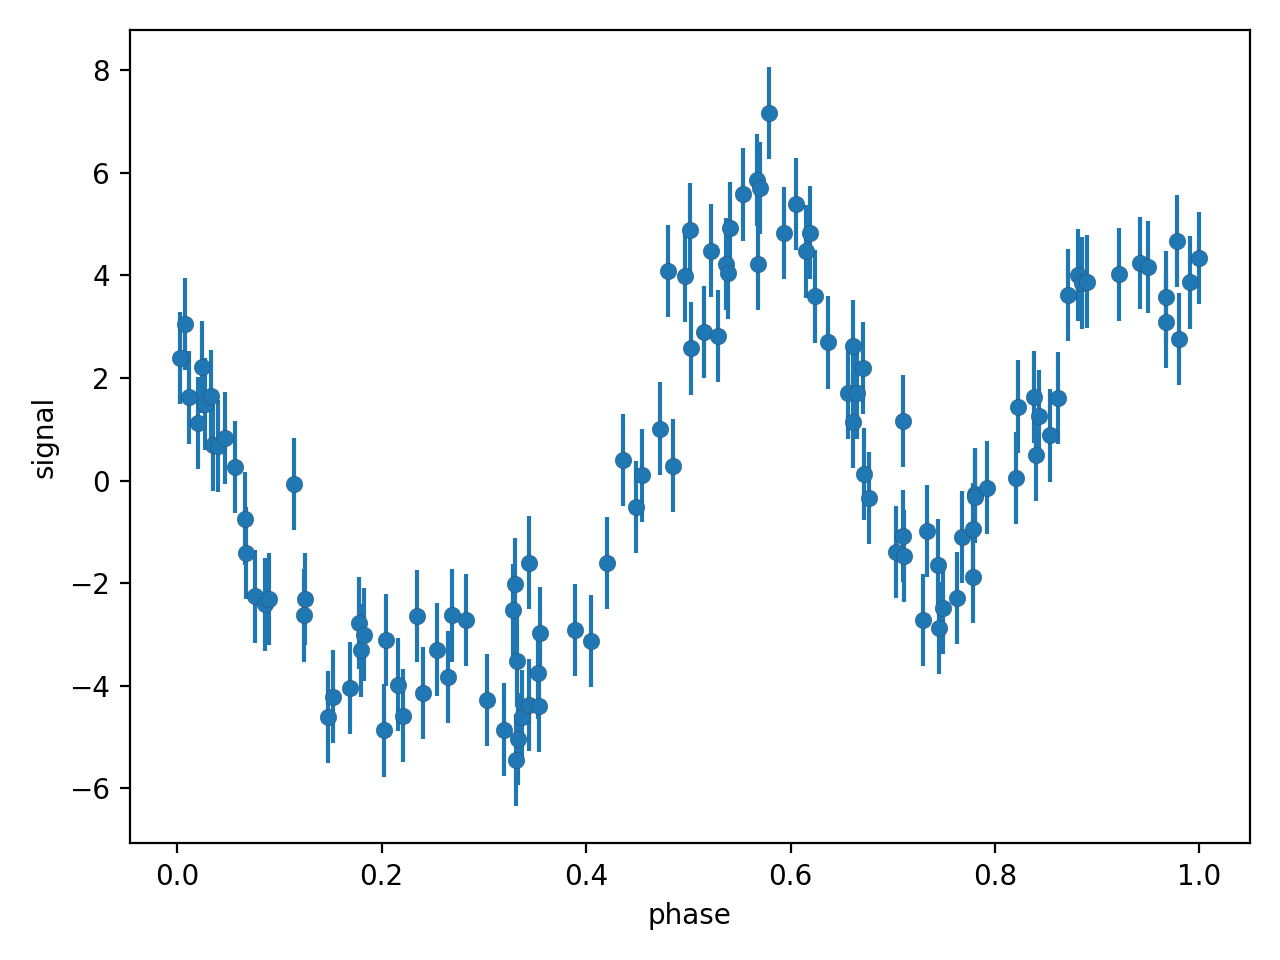

In [6]:
np.random.seed(185)
t_obs = np.random.uniform(60, size=120)
phi = np.pi
var_y = 0.81

y = gen_periodic_data(t_obs, period=0.7, 
                      amplitude=3, phase=phi, 
                      noise=var_y) 
y += gen_periodic_data(t_obs, period=0.7/2, 
                       amplitude=3, phase=phi+np.pi/2)
y += gen_periodic_data(t_obs, period=0.7/3, 
                       amplitude=2, phase=phi)

y_unc = np.ones_like(y)*np.sqrt(var_y)

phase_plot(t_obs, y, 0.7, y_unc = y_unc)

For this simulated data, lets run LS and see what we find.

Top LS period is 0.3501074134644841


<IPython.core.display.Javascript object>


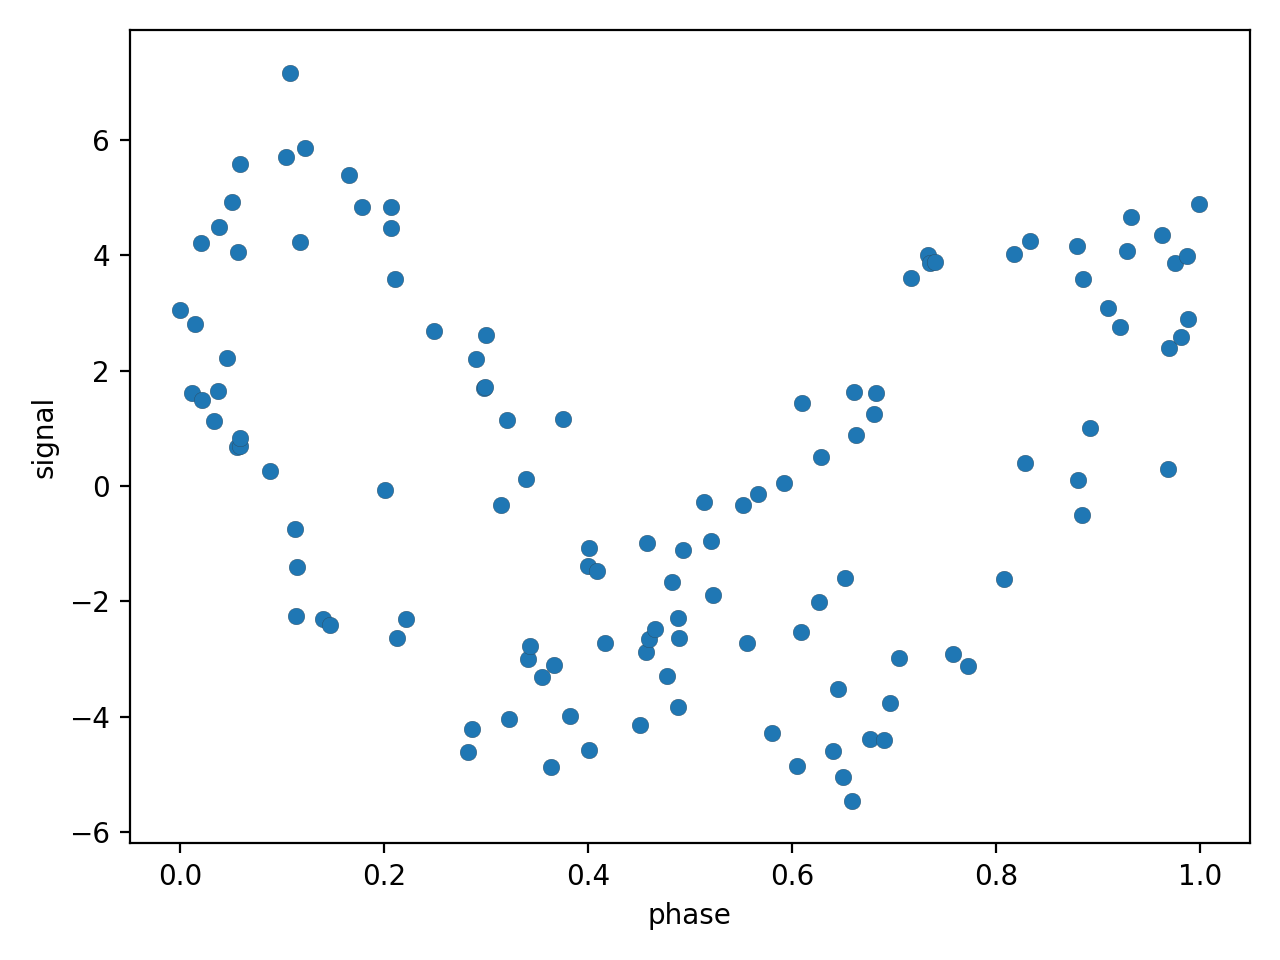

In [7]:
from astropy.timeseries import LombScargle

freq, psd = LombScargle(t_obs, y, y_unc).autopower(maximum_frequency=5)

best_period = 1/freq[np.argmax(psd)]
print('Top LS period is {}'.format(best_period))

phase_plot(t_obs, y, best_period, y_unc = 0.1*np.ones_like(y))

LS only recovers the "half-period" as the correct answer! 

This is a common problem for eclipsing binaries, which are not purely sinusoidal signals.

(As you might expect, the input period in the data that was simulated with 3 harmonic terms can be recovered with [`LombScargle`](https://docs.astropy.org/en/stable/api/astropy.timeseries.LombScargle.html) if more than one harmonic is searched.

Now we will explore several alternatives to LS, and demonstrate that they can be implemented in `python` without too much overhead.

## Method 1) String Length

The string length method ([Dworetsky](http://adsabs.harvard.edu/abs/1983MNRAS.203..917D)), phase folds the data at trial periods and then minimizes the distance to connect the phase-ordered observations.

<img style="display: block; margin-left: auto; margin-right: auto" src="./images/StringLength.png" align="middle">

<div align="right"> <font size="-3">(credit: Gaveen Freer - http://slideplayer.com/slide/4212629/#) </font></div>

**Probelm 1a**

Write a function, `calc_string_length`, that calculates the string length for a phase-folded light curve with observations `x`, `y`, and frequency `f`.

In [9]:
def calc_string_length(x, y, f=1):
    '''Calculate string length for observations at frequency f
    
    Parameters
    ----------
    x : array-like
        input time of observations
    
    y : array-like
        measured signal at input x
    
    f : float (default=1)
        frequency of the test period
        
    Returns
    -------
    sl : float
        String length for the phase-ordered observations
    
    '''
    
    phases = x*f % 1
    sl = np.sum(np.hypot(np.diff(np.sort(phases)), np.diff(y[np.argsort(phases)])))# complete
    return sl

**Problem 1b** 

Write a function `sl_periodogram` to measure the string length for input data `x`, `y`, over a frequency grid `f_grid`.

In [10]:
def sl_periodogram(x, y, f_grid = np.linspace(0.1,10,10)):
    '''Calculate the string length "periodogram"
    
    Parameters
    ----------
    x : array-like
        input time of observations
    
    y : array-like
        measured signal at input x
    
    f_grid : array_like (default=np.linspace(0.1,10,10))
        frequency grid for the period
        
    Returns
    -------
    sl_psd : array_like
        String length at every test frequency f
    
    '''
    
    sl_psd = np.zeros_like(f_grid)
    for f_num, f in enumerate(f_grid):
        sl_psd[f_num] = calc_string_length(x,y,f)# complete
    
    return sl_psd

**Problem 1c**

Plot the string length periodogram for the simulated data. Does it make sense?

*Hint - think about the optimal grid from Notebook III*

<IPython.core.display.Javascript object>


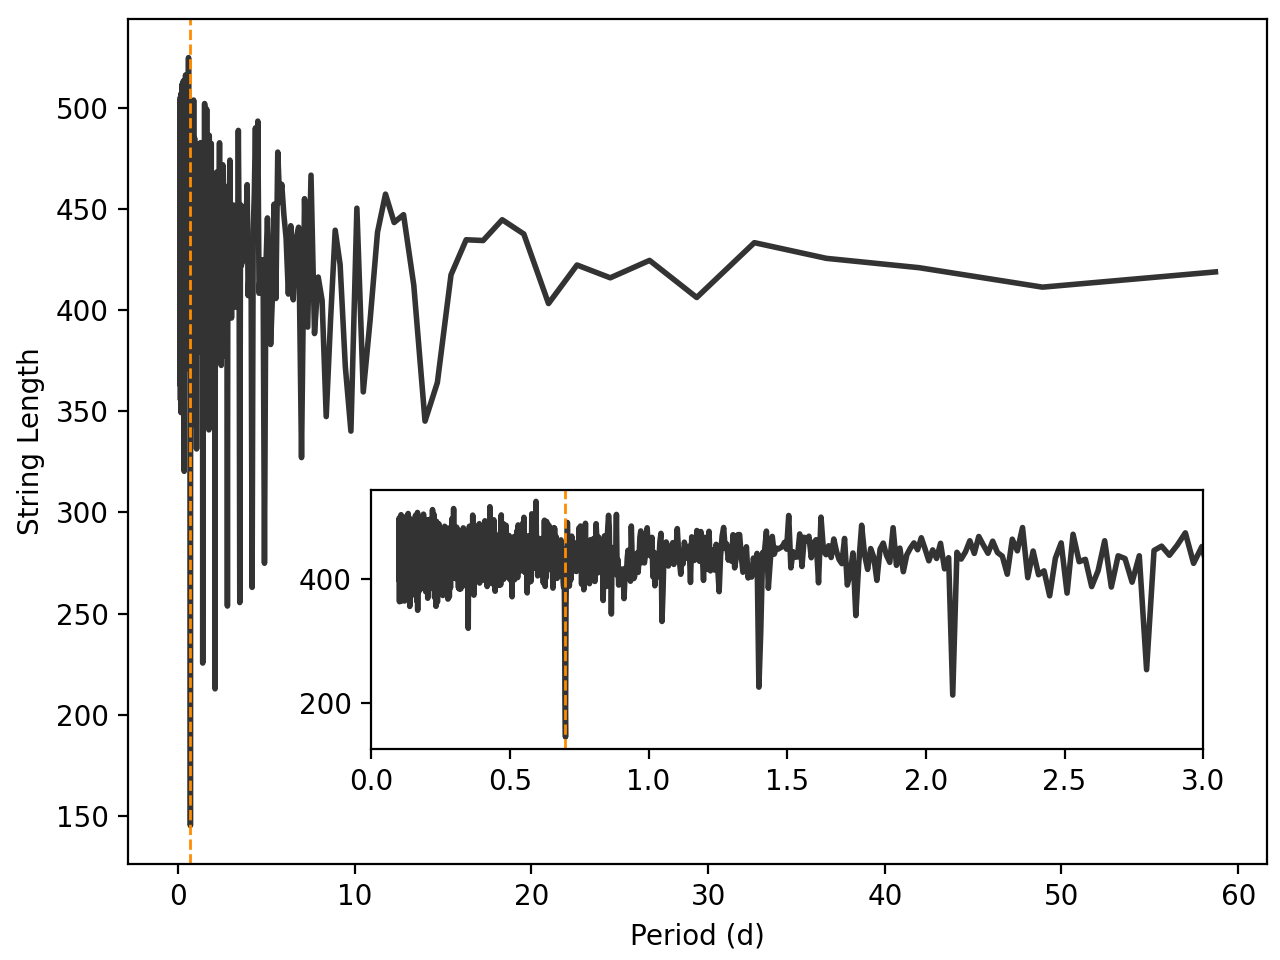

In [11]:
f_grid = np.arange(1/np.ptp(t_obs), 10, 1/5/np.ptp(t_obs))
sl_psd = sl_periodogram(t_obs,y,f_grid) # complete

fig, ax = plt.subplots()
ax.plot(1/f_grid, sl_psd, '0.2', lw=2)
ax.set_xlabel('Period (d)')
ax.set_ylabel('String Length')

ax.axvline(0.7, color='DarkOrange', 
          lw=1, ls='--')

axins = plt.axes([.29, .22, .65, .27])
axins.plot(1/f_grid, sl_psd, '0.2', lw=2)
axins.axvline(0.7, color='DarkOrange',  lw=1, ls='--')
axins.set_xlim(0,3)

fig.subplots_adjust(left=0.1, right=0.99, top=0.98, bottom=0.1)

The string length method was able to recover the correct period for the simulated data. 

The main downside to this method is that it does not account for the observational uncertainties at all.

## Method 2) Phase Dispersion Minimization

Phase Dispersion Minimization (PDM; [Jurkevich 1971](http://adsabs.harvard.edu/abs/1971Ap%26SS..13..154J), [Stellingwerth 1978](http://adsabs.harvard.edu/abs/1978ApJ...224..953S)), like LS, folds the data at a large number of trial frequencies $f$.

The phased data are then binned, and the variance is calculated in each bin, combined, and compared to the overall variance of the signal. No functional form of the signal is assumed, and thus, non-sinusoidal signals can be found.

<img style="display: block; margin-left: auto; margin-right: auto" src="./images/PDM.jpg" align="middle">

<div align="right"> <font size="-3">(credit: Gaveen Freer - http://slideplayer.com/slide/4212629/#) </font></div>

**Problem 2a** 

Write a function called `calc_pdm`, that calculates the average dispersion/scatter in $N$ equally spaced bins for a phase-folded light curve with observations `x`, `y`, and frequency `f`. Specify the number of bins $N$ via keyword argument `bins`.

In [15]:
def calc_pdm(x, y, f=1, bins=10):
    '''Calculate the phase dispersion minimization for observations at frequency f
    
    Parameters
    ----------
    x : array-like
        input time of observations
    
    y : array-like
        measured signal at input x
    
    f : float (default=1)
        frequency of the test period
    
    bins : int (default=10)
        
    Returns
    -------
    pdm : float
        the sum of the scatter in each bin
    '''
    phases = x*f % 1
    pdm = 0
    for bin_num in range(bins):
        this_bin = np.where((phases>=bin_num/10) & 
                            (phases < (bin_num+1)/bins))
        if len(this_bin[0]) > 1:
            pdm+= np.std(y[this_bin],ddof=1)/bins
        
    return pdm


**Problem 2b** 

Write a function `pdm_periodogram` to measure the relative reduction in the scatter for a phase-folded light curve with input data `x`, `y`, over a frequency grid `f_grid`.

Plot the periodogram.

In [13]:
def pdm_periodogram(x, y, f_grid = np.linspace(0.1,10,10), **kwargs):
    '''Calculate the phase dispersion minimization "periodogram"
    
    Parameters
    ----------
    x : array-like
        input time of observations
    
    y : array-like
        measured signal at input x
    
    f_grid : array_like (default=np.linspace(0.1,10,10))
        frequency grid for the period
        
    Returns
    -------
    pdm_psd : array_like
        PDM at every test frequency f
    
    '''
    
    pdm_psd = np.zeros_like(f_grid)
    total_rms = np.std(y, ddof=1)
    for f_num, f in enumerate(f_grid):
        pdm_psd[f_num] = calc_pdm(x,y,f)/total_rms # complete
    
    return pdm_psd

The best-fit period is 0.7006 d


<IPython.core.display.Javascript object>


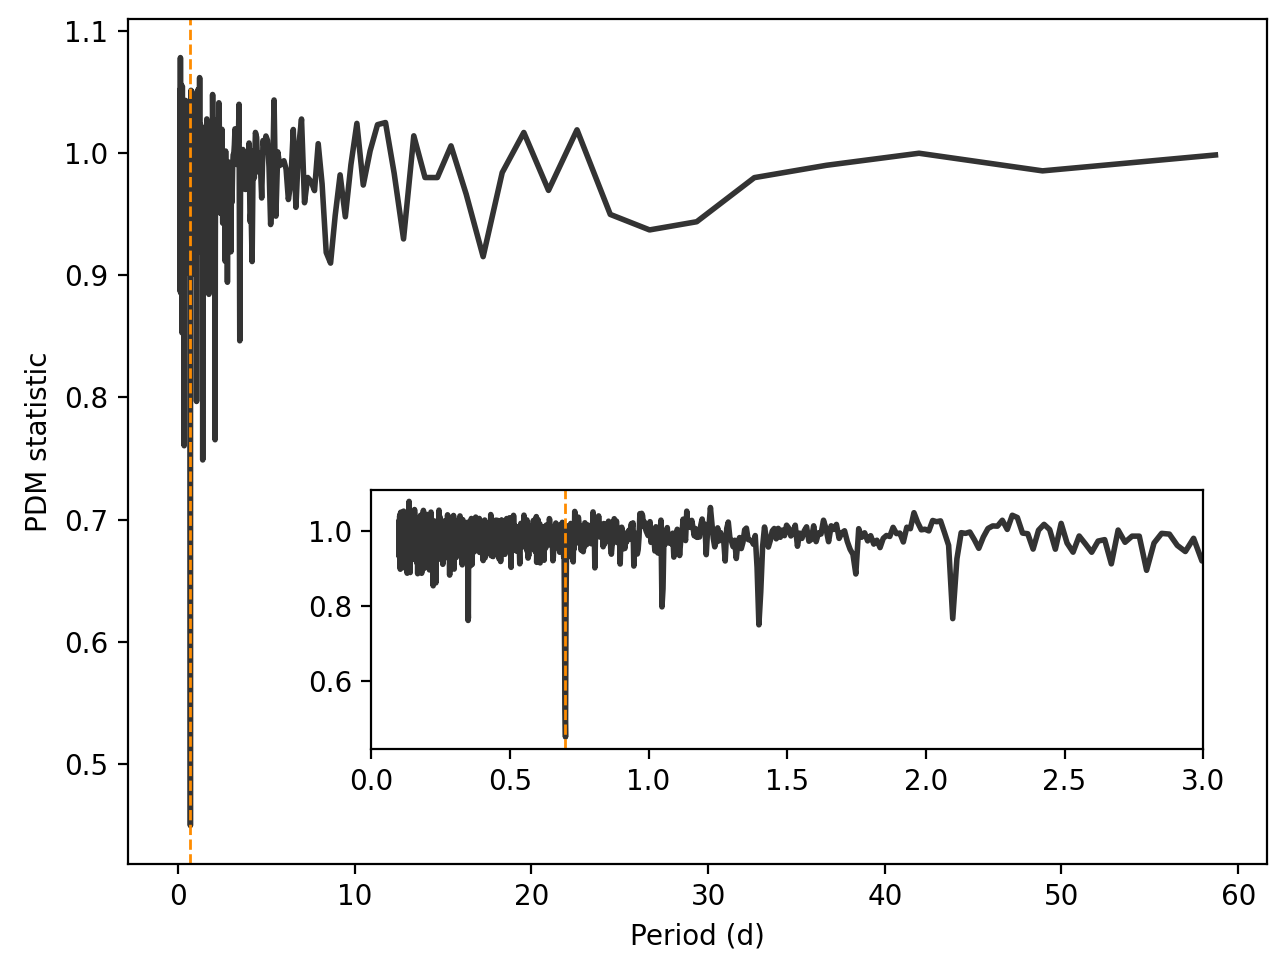

In [16]:
f_grid = np.arange(1/np.ptp(t_obs), 10, 1/5/np.ptp(t_obs))
pdm_psd = pdm_periodogram(t_obs,y,f_grid) # complete

print(f'The best-fit period is {1/f_grid[np.argmin(pdm_psd)]:.4f} d')

fig, ax = plt.subplots()
ax.plot(1/f_grid, pdm_psd, '0.2', lw=2)
ax.set_xlabel('Period (d)')
ax.set_ylabel('PDM statistic')
ax.axline((0.7,np.mean(pdm_psd)), (0.7, np.mean(pdm_psd)+1e-3), 
          color='DarkOrange',  lw=1, ls='--')


axins = plt.axes([.29, .22, .65, .27])
axins.plot(1/f_grid, pdm_psd, '0.2', lw=2)
axins.axline((0.7,np.mean(pdm_psd)), (0.7, np.mean(pdm_psd)+1e-3), 
          color='DarkOrange',  lw=1, ls='--')
axins.set_xlim(0,3)
fig.subplots_adjust(left=0.1, right=0.99, top=0.98, bottom=0.1)


PDM finds the correct period! 

Like string length, PDM does not incorporate observational uncertainties, though a slight modification to measure the $\chi^2$ rather than the scatter can correct that. 

The main challenge for PDM is deciding the number of bins to adopt. For some light curves the choice of 10 or 100 bins can result in different measurements of the best period.

## Method 3) Analysis of Variance

Analysis of Variance (AOV; [Schwarzenberg-Czerny 1989](http://adsabs.harvard.edu/abs/1989MNRAS.241..153S)) is similar to PDM. Optimal periods are defined via hypothesis testing, and these methods are found to perform best for certain types of astronomical signals.

## Method 4) Supersmoother

Supersmoother ([Reimann](http://adsabs.harvard.edu/abs/1994PhDT........20R)) is a least-squares approach wherein a flexible, non-parametric model is fit to the folded observations at many trial frequncies. The use of this flexible model reduces aliasing issues relative to models that assume a sinusoidal shape, however, this comes at the cost of requiring considerable computational time. 

Briefly, supersmoother provides a smooth estimate of the data via localized linear regression. Observations are then compared to the smooth model value to identify the model that optimally reduces the sum of the square of the residuals (normalized by the uncertainties when available). 

Supersmoother requires a user-selected smoothing window (called the "span"), a sliding region over which the linear fit is performed. 

The "magic" in supersmoother is that it uses cross-validation to identify the optimal span at every location within the data set.

The supersmoother psuedo-code is:  


 1. create 3 smooth local linear estimations of `y` at every input `x` with `span` = 0.05, 0.2, and 0.5

   2. identify optimal `span` at every `x` based on residuals


  3. smooth the above "optimal" span curve with `span` = 0.2


  4. create a "final" smooth estimate by interpolating bewtween two smooth curves closest in value to (3)

We will now illustrate how this works via several examples (before putting everything together into a single function). 

**Problem 4a**

Write a function `smooth` that estimates the value of `y` at every phase `phase` via a linear least squares fit to all the observations within $\pm$`span`/2 of `phase`. The observed value of `y` at phase `phase` should be excluded from the fit. 

*Hint* - it may be helpful to input `x` and `f` so the phase can be calculated within the function. Note - you can "supersmooth" any series of data, a frequency is not strictly required.

In [17]:
def smooth(y, x, f=None, span=0.05, y_unc=None):
    '''Calculate the smooth
    
    Parameters
    ----------
    x : array-like
        input time of observations
    
    y : array-like
        measured signal at input x
    
    f : float (optional; default=None)
        frequency for which to calculate the smooth.
        if None, then the x values are normalized 
        between 0 and 1.

    y_unc : array-like (optional; default=None)
        uncertainties on the input signal
        
    Returns
    -------
    smooth : array_like
        smooth estimate of the phase folded frequency
    '''
    
    if type(y_unc) == int:
        y_unc = np.ones_like(y)*y_unc
        
    if f is None:
        phases = (x - np.min(x))/(np.ptp(x))
    else:
        phases = (x*f) % 1
    
    smooth=np.empty_like(x)
    for obs_num, phase in enumerate(phases):
        this_fit = np.where((phases >= phase - span/2) & 
                            (phases < phase + span/2) & 
                            (phases != phase) & 
                            # Kludge for numerical stability
                            (len(np.where((phases >= phase - span/2) & 
                                          (phases < phase))[0]) > 0
                            ) & 
                            # ask about this during Q&A
                            (len(np.where((phases < phase + span/2) & 
                                          (phases > phase))[0]) > 0
                            )
                           )
        # catch instances where there is not enough data to fit a line
        if len(this_fit[0]) > 1:
            if y_unc is not None:
                lin_fit = np.poly1d(np.polyfit(phases[this_fit],
                                               y[this_fit],
                                               1, 
                                               w = 1/y_unc[this_fit]))
            else:
                lin_fit = np.poly1d(np.polyfit(phases[this_fit],
                                               y[this_fit],
                                               1))
            smooth[obs_num] = lin_fit(phase)
        else:
            smooth[obs_num] = -np.inf

        
    # use linear interpolation to fill in missing smooth
    missing_smooth = np.isinf(smooth)
    smooth[missing_smooth] = np.interp(phases[missing_smooth], 
                                       np.sort(phases[~missing_smooth]), 
                                       smooth[~missing_smooth][np.argsort(phases[~missing_smooth])])
        
    return smooth



**Problem 4b**

Plot the smooth representation of the data with spans of 0.05, 0.2, and 0.5 folded at a period of 0.7 d. 

*pseudocode 1*

<IPython.core.display.Javascript object>


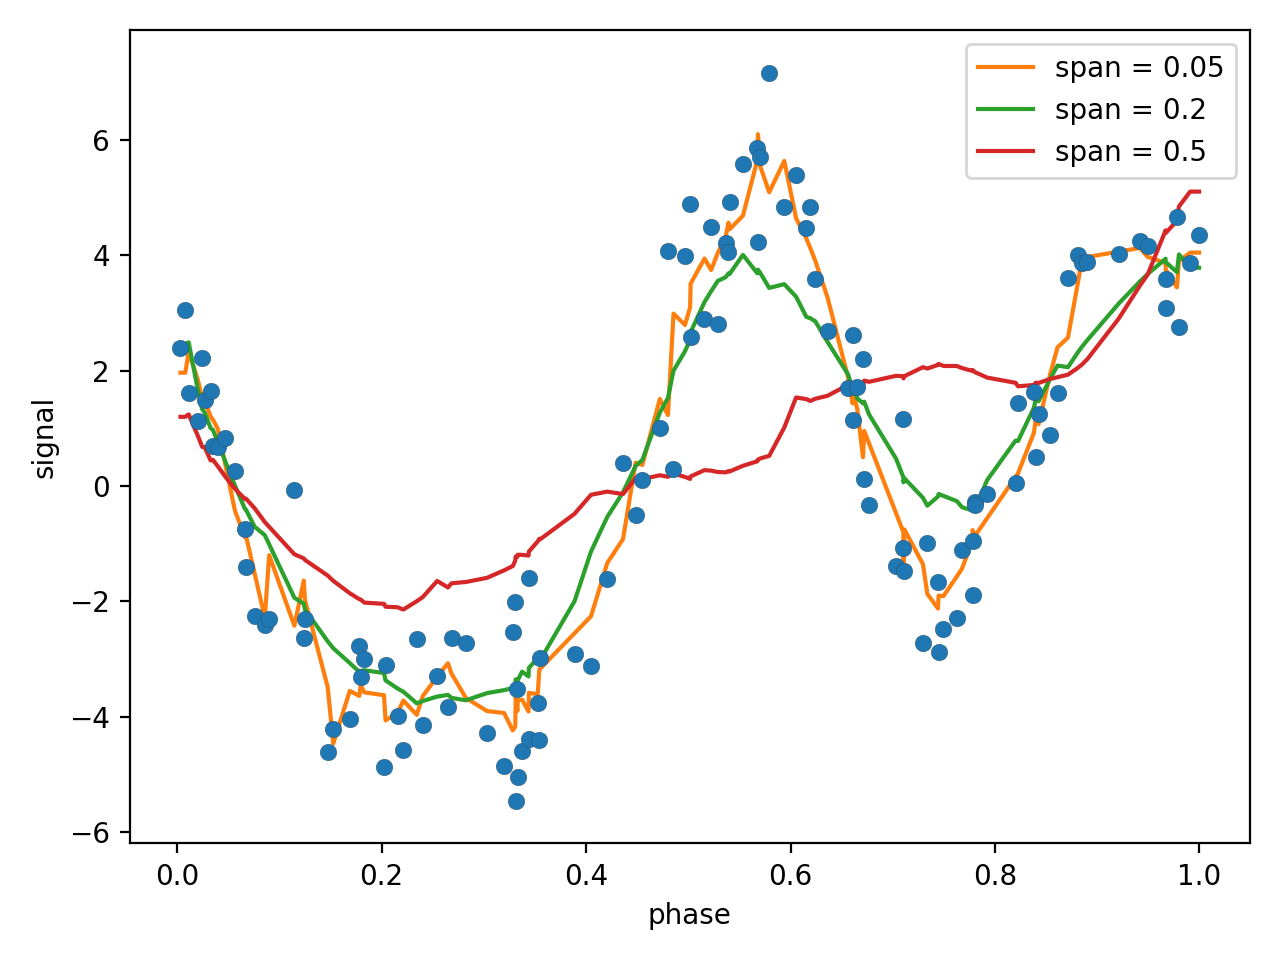

In [18]:
phases = (t_obs/0.7) % 1

smooth_tweeter = smooth(y, t_obs, 1/0.7, span=0.05, y_unc=y_unc)
smooth_midrange = smooth(y, t_obs, 1/0.7, span=0.2, y_unc=y_unc)
smooth_woofer = smooth(y, t_obs, 1/0.7, span=0.5, y_unc=y_unc)

phase_plot(t_obs, y, 0.7, y_unc = 0.1*np.ones_like(y))
plt.plot(np.sort(phases), smooth_tweeter[np.argsort(phases)], 
       label="span = 0.05")
plt.plot(np.sort(phases), smooth_midrange[np.argsort(phases)], 
       label="span = 0.2")
plt.plot(np.sort(phases), smooth_woofer[np.argsort(phases)], 
       label="span = 0.5")
plt.legend()

We now have 3 different "smooth" representations of the data. But even these "smooth" representations are a bit jagged, and in places we can see the influence of noise.

We will now identify the "optimal" span at every phase.

**Probem 4c**

Identify the best span at every phase via the residuals. 

*pseudocode 2*

In [19]:
smooth_list = np.vstack([[smooth_tweeter], 
                         [smooth_midrange],
                         [smooth_woofer]])
span_list = np.vstack([[np.ones_like(smooth_tweeter)*0.05], 
               [np.ones_like(smooth_midrange)*0.2],
               [np.ones_like(smooth_woofer)*0.5]])
resid = np.abs(y - smooth_list)

best_span = span_list[np.argmin(resid, axis=0), 0]

**Problem 4d**

Smooth the `best_span` array using a `span = 0.2`, to create a smooth representation of the best smooth.

*pseudocode 3*

<IPython.core.display.Javascript object>


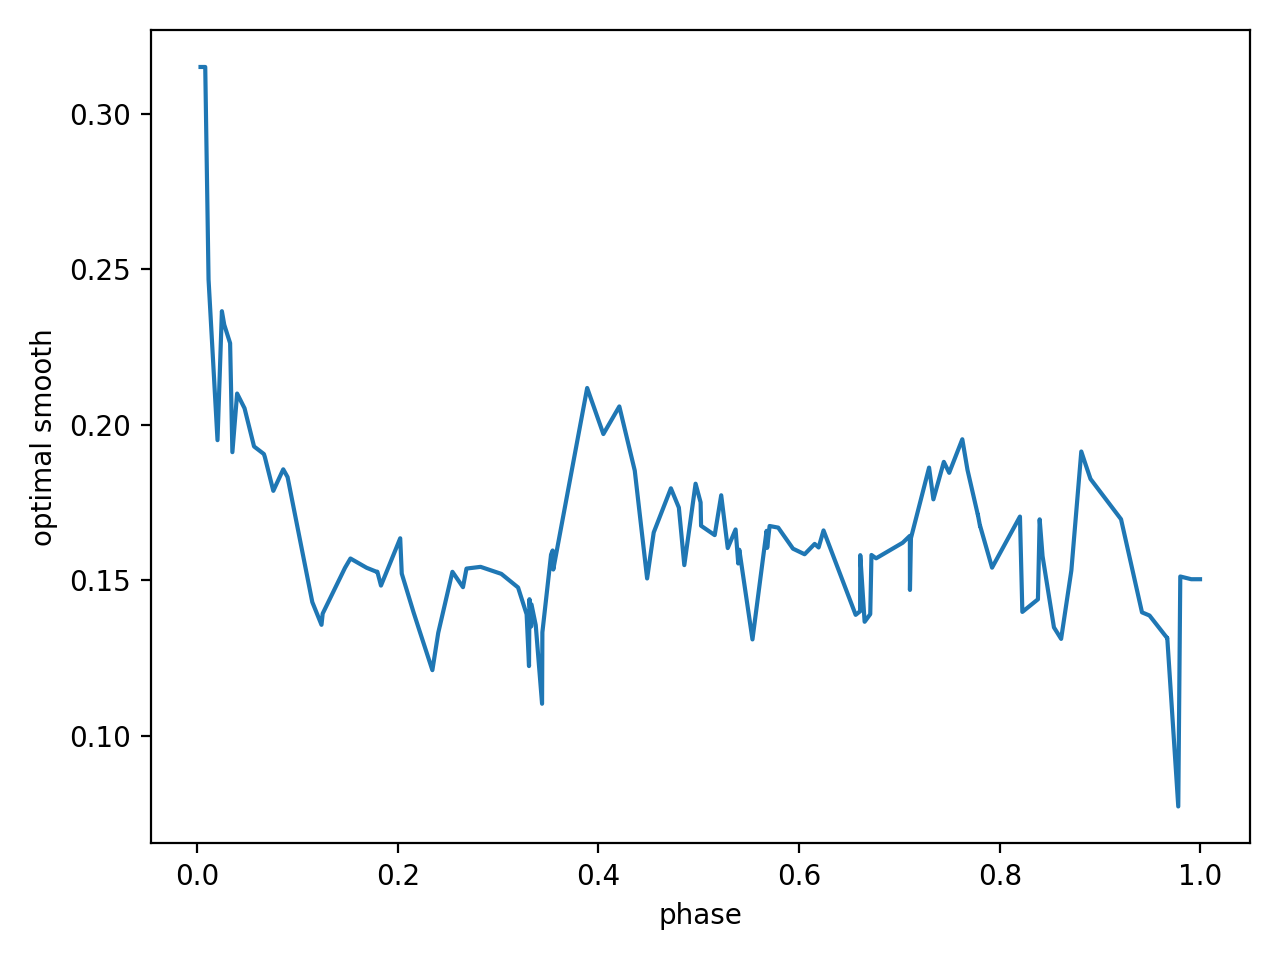

In [20]:
span_midrange = smooth(best_span, t_obs, 1/0.7, span=0.2)

fig, ax = plt.subplots()
ax.plot(np.sort(phases), span_midrange[np.argsort(phases)])
ax.set_xlabel('phase')
ax.set_ylabel('optimal smooth')
fig.tight_layout()

**Problem 4e**

Calculate the "super" smooth representation of the data by interpolating from the 3 initial smooth estimates to the `span_midrange` estimate.

*pseudocode 4*

In [21]:
supersmooth = np.empty_like(smooth_midrange)
for sm_num, sm in enumerate(span_midrange):
    supersmooth[sm_num] = np.interp(sm, 
                                    span_list.T[sm_num], 
                                    smooth_list.T[sm_num])

**Problem 4f**

Plot the supersmooth over the phase-folded data.

<IPython.core.display.Javascript object>


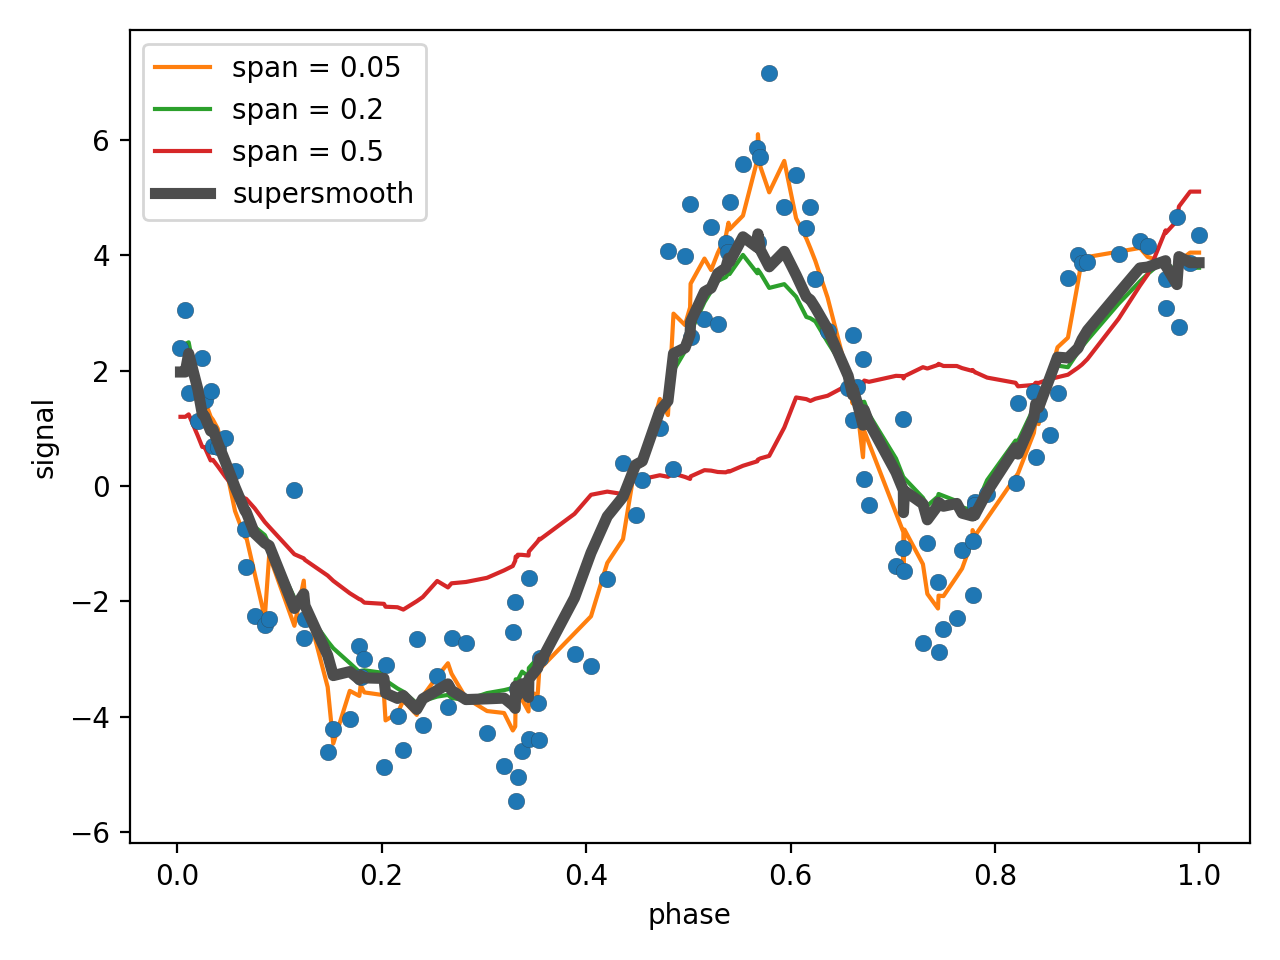

In [22]:
phases = (t_obs/0.7) % 1

phase_plot(t_obs, y, 0.7, y_unc = 0.1*np.ones_like(y))
plt.plot(np.sort(phases), smooth_tweeter[np.argsort(phases)], 
       label="span = 0.05")
plt.plot(np.sort(phases), smooth_midrange[np.argsort(phases)], 
       label="span = 0.2")
plt.plot(np.sort(phases), smooth_woofer[np.argsort(phases)], 
       label="span = 0.5")
plt.plot(np.sort(phases), supersmooth[np.argsort(phases)], 
         lw=4, color='0.3', zorder=10, 
         label='supersmooth')
plt.legend()

**Problem 4g**

Wrap everything from above into a single function `calc_supersmooth`.

In [23]:
def calc_supersmooth(y, x, f=None, spans=[0.05, 0.2, 0.5], y_unc=None):
    '''Calculate the smooth
    
    Parameters
    ----------
    x : array-like
        input time of observations
    
    y : array-like
        measured signal at input x
    
    f : float (default=None)
        frequency for which to calculate the smooth.
        if None, then the x values are normalized 
        between 0 and 1.

    spans : list (default=[0.05, 0.2, 0.5])
        list of the individual spans to use for the 
        initial smooth representations of the data

    y_unc : array-like (default=None)
        uncertainties on the input signal
    
    Returns
    -------
    supersmooth : array_like
        smooth estimate of the phase folded frequency
    '''
    if type(y_unc) == int:
        y_unc = np.ones_like(y)*y_unc
        
    if f is None:
        phases = (x - np.min(x))/(np.ptp(x))
    else:
        phases = (x*f) % 1

    smooth_list = np.vstack([[smooth(y, x, f, span=s, y_unc=y_unc) for s in spans]])
    span_list = np.ones_like(smooth_list)*np.array(spans)[:,None]
    
    resid = np.abs(y - smooth_list)
    
    span_midrange = smooth(span_list[np.argmin(resid, axis=0), 0], 
                           x, f, span=np.median(spans))
    
    supersmooth = np.empty_like(smooth_midrange)
    for sm_num, sm in enumerate(span_midrange):
        supersmooth[sm_num] = np.interp(sm, 
                                        span_list.T[sm_num], 
                                        smooth_list.T[sm_num])
    
    return supersmooth



**Problem 4h**

Write a function `supersmooth_periodogram` to calculate the Supersmoother periodogram. 

Unlike the other methods above, we can in this case calculate $\chi^2$ at each frequency. Use $\chi^2_0$ as a relative baseline as we did in calculating the LS periodogram.

In [24]:
def supersmooth_periodogram(y, y_unc, x, f_grid):
    psd = np.empty_like(f_grid)
    chi2_0 = np.sum(((y - np.mean(y))/y_unc)**2)
    
    for f_num, f in enumerate(f_grid):
        supersmooth = calc_supersmooth(y, x, f, y_unc=y_unc)
        chi2 = np.sum((y - supersmooth)**2/y_unc**2)
        psd[f_num] = 0.5*(chi2_0 - chi2)
    
    return psd

**Problem 4i**

Calculate and plot the supersmoother periodogram for the simulated data. 

*Hint* - this is much slower than above, use a frequency grid that goes from 0.6 to 3 and has 1000 points.

<IPython.core.display.Javascript object>


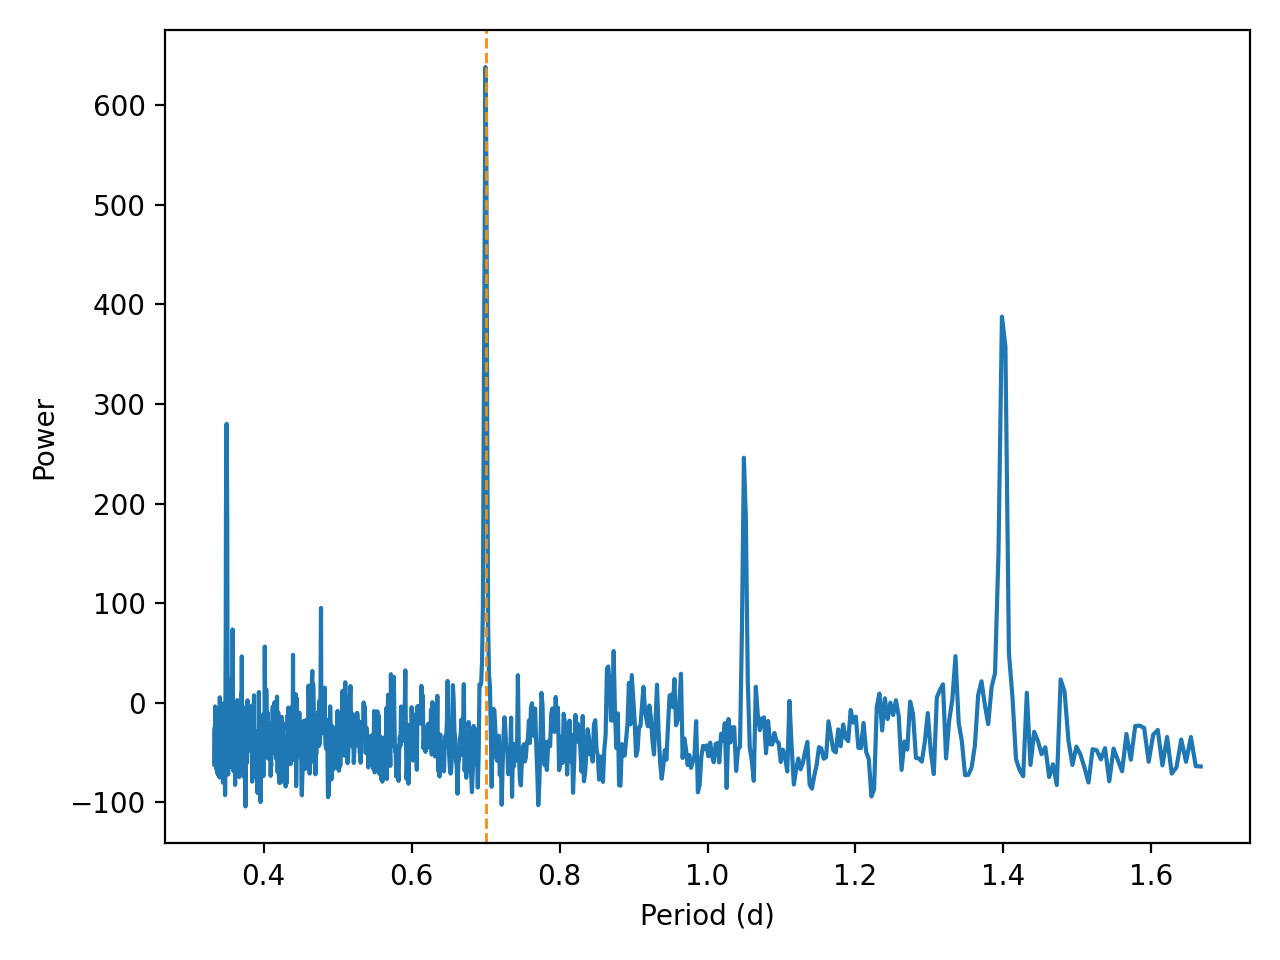

In [25]:
f_grid = np.linspace(0.6, 3, 1000)

ss_psd = supersmooth_periodogram(y, y_unc, t_obs, f_grid)

fig, ax = plt.subplots()
ax.plot(1/f_grid, ss_psd)
ax.axvline(0.7, color='DarkOrange', 
          lw=1, ls='--')
ax.set_xlabel('Period (d)')
ax.set_ylabel('Power')
fig.tight_layout()

The grand downside of supersmoother should now be obvious - this thing is S - L - O - W, slow. 

We only ran a frequency grid with only 1000 points and it still took significantly longer than the other methods.

Fortunately, Jake VanderPlas has created a faster implementation of [SuperSmoother](https://www.astroml.org/gatspy/periodic/supersmoother.html), if you are interested in implementing this method. 

We have just now covered 4 (4!) alternatives to LS for measuring periodicity (and Notebook IV involves yet another). 

There is something that should really be bothering you at this point though...


Absolutely none of the methods we have covered provide any sort of measurement of uncertainty on the best-fit period estimates. And uncertainty is at the heart of all meaningful analysis.

## Bayesian Methods

There have been some efforts to frame the period-finding problem in a Bayesian framework. [Bretthorst 1988](https://www.springer.com/us/book/9780387968711) developed Bayesian generalized LS models, while [Gregory & Loredo 1992](http://adsabs.harvard.edu/abs/1992ApJ...398..146G) applied Bayesian techniques to phase-binned models. 

More recently, efforts to use Gaussian processes (GPs) to model and extract a period from the light curve have been developed ([Wang et al. 2012](http://adsabs.harvard.edu/abs/2012ApJ...756...67W)). These methods have proved to be especially useful for detecting stellar rotation in Kepler light curves ([Angus et al. 2018](http://adsabs.harvard.edu/abs/2018MNRAS.474.2094A)). 


## Method 5) GPs + the Quasi-Periodic Kernel

Our desired goal is to get some form of probabilistic estimate on the period. This can be done using a GP plus some Bayesian inference techniques, as the references above demonstrate.

(I realize that for half of you we have not yet had a chance to cover Bayesian statistics. I'm going to provide a woefully short intro/review here, but I'm otherwise writing things in a way that I hope is general enough to see the utility of the following method).

Here is my ridiculously short review/intro to Bayesian analysis for this problem: the posterior $P(\theta|x)$ (i.e., the probability distribution for the model parameters) is proportional to the likelihood multiplied by the prior:

$$P(\theta|x) \propto P(x|\theta)P(\theta)$$

where $P(x|\theta)$ is the likelihood, $P(\theta)$ is the prior, $\theta$ is a vector of all the model parameters, and $x$ is the data.

In many applications, including this one, the likelihood $\mathcal L$, specifically the $\ln \mathcal{L}$, is essentially the familiar form of what we often call $\chi^2$. There can be important implications for the prior but for this example we will find that the prior does not significantly the final probability densities for the model parameters (in part because we have really good data for constraining the period of this particulat eclipsing binary). Thus, we will adopt "wide and flat" priors, which are adopted by many, but I'll warn not always the absolute best idea for analysis like this.

We will adopt a "standard" gaussian likelihood (which reduces to the $\chi^2$ when we calculate the log of the likelihood). 

All we need now is a model for the signal at every time, $t$, or position, $x$.

We will model the data as a Gaussian process (GP). In this case we know the signal is periodic (we have an EB). 

For periodic signals it is common to adopt a cosine kernel for the GP covariance function. As we saw in Notebook III, this particular EB does not have a purely sinusoidal signal (due to the difference in the depths of the two eclipses). 

Instead, we will adopt the quasi-periodic kernel: 

$$K_{ij} = k(x_i - x_j) = \exp \left(-\Gamma \sin^2\left[\frac{\pi}{P} \left|x_i - x_j\right|\right]\right)$$

which is extremely useful for periodic (or quasi-periodic) data with non-sinusoidal signals.

**Problem 5a**

Load the light curve from the example EB from Notebook III, and plot the phase folded light curve at the previously identified "optimal" period $0.735085\,\mathrm{d}$.

<IPython.core.display.Javascript object>


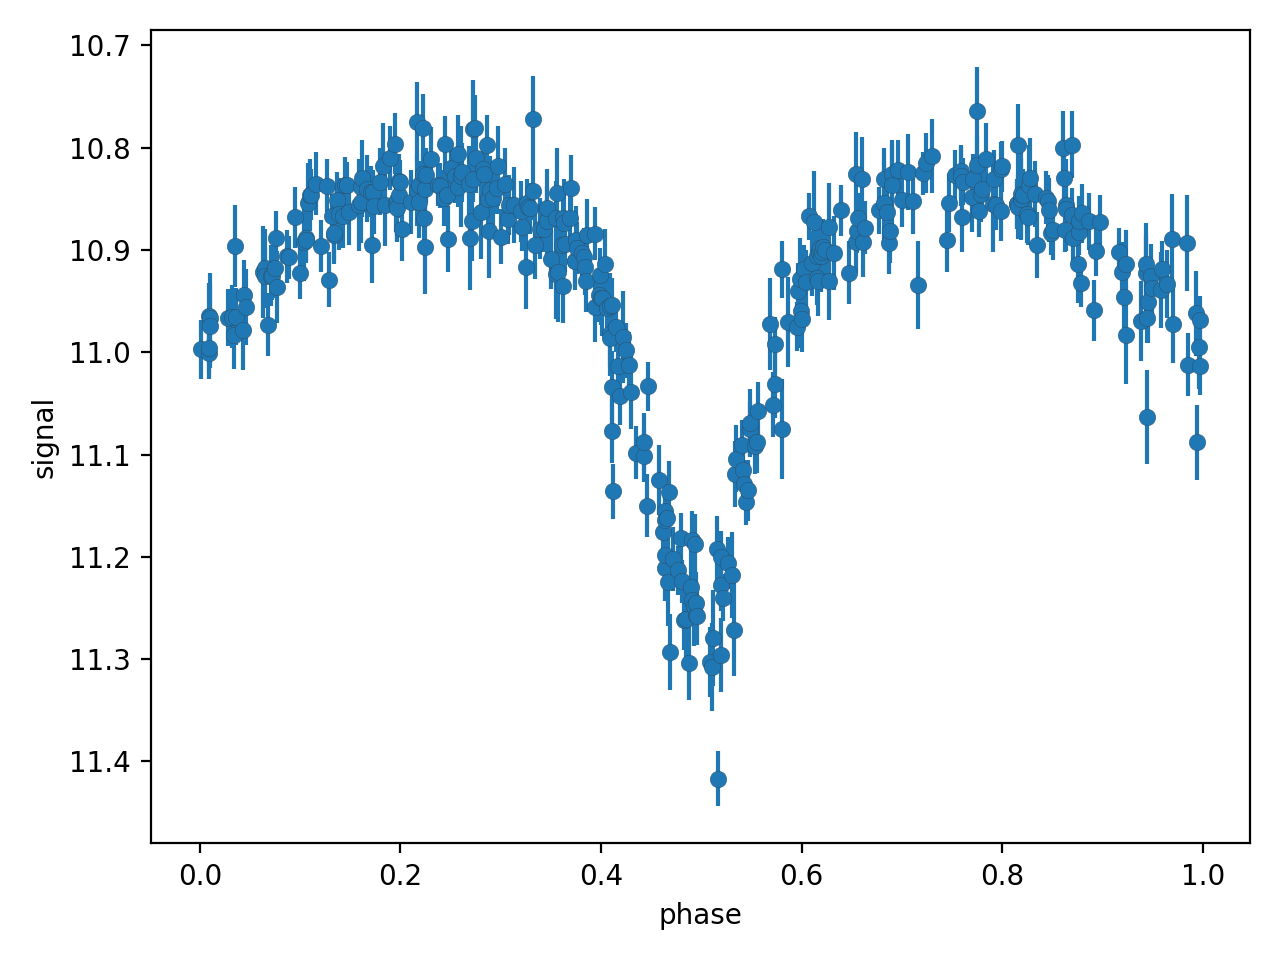

In [27]:
lc = pd.read_csv("example_asas_lc.dat")

phase_plot(lc['hjd'], lc['mag'], 0.735085, lc['mag_unc'], 
           mag_plot=True)

Evaluating the quasi-periodic (really any) GP kernel when the number of observations is large is computationally expensive. For this purpose we will use [`george`](https://github.com/dfm/george), which performs the necessary matrix algebra quickly. 

We do not have time for a true introduction to `george`, but I encourage you to [read the docs](https://george.readthedocs.io/en/latest/).

In [29]:
import os,sys,csv
insert_path=os.path.abspath('/opt/miniconda3/lib/python3.9/site-packages')
sys.path.insert(0,insert_path)
import george
from george import kernels

ModuleNotFoundError: No module named 'george.kernel_interface'

For the MCMC sampling we will use [`emcee`](https://emcee.readthedocs.io/en/stable/index.html), again there is not time for a full introduction. This software will be covered in greater detail elsewhere in the DSFP. 

It's advantage for our present purposes is that it is written in pure python, and can accept any user defined function for the posterior. It also integrates very nicely with `george`.

In brief, `emcee` uses multiple MCMC chains that simultaneously explore the posterior probability. During each step within the chain, individual chains (called "walkers") will effectively query the other walkers in order to identify the optimal next step in the chain. 

Multiple chains enables "easy" parallelization, though we will not focus on that today as `george` is already highly optimized to use mutliple CPU cores.

**Problem 5b**

Write a function `model` that returns the "mean model" for the GP. The two arguments for this function should be a tuple `theta` of length 4, where the 3rd element is the "mean" `b`, and the time of observation `t`.

In [ ]:
def model(theta, t):
    _, _, b, _ = theta
    return b

**Problem 5c**

Write a function `lnlike` to calculate the log likelihood for the data given the model parameters `theta`. `theta` should include the log of the period, the log of the amplitude of the signal, the GP mean value `b`, and the log of $\Gamma$.

*Hint* - execute cell below.

$\log$ in all instances here and below refers to the natural logarithm, or $\log$ base $\mathcal{e}$.

In [ ]:
def lnlike(theta, t, y, yerr):
    lnper, lna, b, lngamma = theta
    gp = george.GP(np.exp(lna) * 
                   kernels.ExpSine2Kernel(np.exp(lngamma), lnper))
    gp.compute(t, yerr)
    return gp.lnlikelihood(y - model(theta, t), quiet=True)


**Problem 5d**

Write a function `lnprior` to calculate the log of the prior on `theta`. Use a wide and flat prior on every parameter. For numerical reasons, the function should return `-np.inf` if the prior probability is equal to zero.

*Hint* - execute the cell below

In [ ]:
def lnprior(theta):
    lnper, lna, b, lngamma = theta
    if (-20 < lna < 20 and 
        -20 < b < 20 and 
        -20 < lngamma < 20 and
        -10 < lnper < np.log(10)):
        return 0.0
    return -np.inf

**Problem 5e**

Write a function `lnprob` to calculate the log of the product of the likelihood with the prior. 

In [ ]:
def lnprob(p, x, y, yerr):
    lp = lnprior(p)
    return lp + lnlike(p, x, y, yerr) if np.isfinite(lp) else -np.inf

We need a starting position for our MCMC chains/walkers. The use of a quasi-periodic kernel means the posterior is highly non-linear, so we cannot expect to start the walkers anywhere and still achieve reasonable results. 

In this case we will use a little common sense, plus a little computational "brute force". 

**Problem 5f**

Run `LombScarge` on the data and determine the top three peaks in the periodogram. Set `nterms` = 2, and the maximum frequency to 5 (this is arbitrary but sufficient in this case, since the period is > 0.2 d).

*Hint* - you may need to search more than the top 3 periodogram values to find the 3 peaks.

In [Angus et al. 2018](http://adsabs.harvard.edu/abs/2018MNRAS.474.2094A) a far more sophisticated approach is used for initializing the walkers using the autocorrelation function and adjusting the prior on $P$ - if you want to use GPs to infer periods for real observations I cannot recommend that source enough.

In [ ]:
frequency, power = LombScargle(lc['hjd'], lc['mag'], lc['mag_unc'], nterms=2).autopower(maximum_frequency=5)

print('Top LS period is {}'.format(1/frequency[np.argmax(power)]))
print(1/frequency[np.argsort(power)[::-1][0:5]])

**Problem 5g**

Initialize one third of your 150 walkers around each of the periods identified in the previous problem. 

Run the MCMC for 500 steps following this initialization.

In [ ]:
initial1 = np.array([np.log(0.735), 1, 10, 1])
ndim = len(initial1)
nwalkers = 50
p1 = [np.array(initial1) + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

initial2 = np.array([np.log(0.367), 1, 10, 1])
ndim = len(initial2)
nwalkers = 50
p2 = [np.array(initial2) + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

initial3 = np.array([np.log(0.211), 1, 10, 1])
ndim = len(initial3)
nwalkers = 50
p3 = [np.array(initial3) + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]
p0 = p1+p2+p3

nwalkers = len(p0)


In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(lc['hjd'],lc['mag'],lc['mag_unc']))
for sample in sampler.sample(p0, iterations=500, progress=True):
    continue

**Problem 5h**

Plot the chains using the `plotChains()` helper function from the end of this notebook.

In [ ]:
paramsNames = ['ln(P)', 'ln(a)', 'b', '$ln(\gamma)$']
nburn = 350
plotChains(sampler, nburn, paramsNames)
plt.tight_layout()

**Problem 5i** 

Plot $\ln P$ vs. log posterior. 

In [ ]:
chain_lnp_end = sampler.chain[:,-1,0]
chain_lnprob_end = sampler.lnprobability[:,-1]
fig, ax = plt.subplots()
ax.scatter(chain_lnp_end, chain_lnprob_end, alpha=0.1)
ax.set_xlabel('ln(P)')
ax.set_ylabel('ln(Probability)')
fig.tight_layout()

**Problem 5j**

Now we will start a new set of MCMC chains all initialized around a "random ball" centered on the maximum a posteriori value from the previous set of simulations.$^\dagger$

Run a new MCMC with 150 walkers for 500 steps. 

Plot the chains. Have they converged?

$^\dagger$It is important to remember there are no rules about where an MCMC chain is initialized. We can do whatever we want. I also caution to be mindful of this in future research endeavors, because there is also no guarantee that a finite MCMC chain has identified a global maximum for the posterior. 

In [ ]:
p = p0[np.argmax(chain_lnprob_end)]
sampler.reset()

In [ ]:
p0 = [p + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]
sampler.reset() # do not continue the existing chains
for sample in sampler.sample(p0, iterations=500, progress=True):
    continue

In [ ]:
paramsNames = ['ln(P)', 'ln(a)', 'b', '$ln(\gamma)$']
nburn = 250
plotChains(sampler, nburn, paramsNames)
plt.tight_layout()

**Problem 5k**

Make a corner plot of the samples. What is the marginalized estimate$^\dagger$ for the period of this source? 

How does this estimate compare to LS?

Given that we ultimately used wide and flat priors, which effectively played no role in the analysis of this problem, the discerning viewer might ask "Why did we bother to use Bayesian analysis at all?"

This problem answers that question – the data cannot be "marginalized" (i.e., we ignore everything but the final distribution on the period $P$) in any context except a Bayesian one. Ultimately, marginalization requires an integral where we "integrate out" our ignorance of the model parameters that we do not care about. These sorts of integrals require a Bayesian view of probability.

In [ ]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
plot_samples = samples.copy()
plot_samples[:,0] = np.exp(samples[:,0])
fig = corner.corner(plot_samples, 
                    labels=paramsNames, 
                    quantiles=[0.16,0.50,0.84])

In [ ]:
p16, p50, p84 = np.percentile(samples[:,0], [16,50,84])

print('ln(P) = {:.6f} +{:.6f} -{:.6f}'.format(p50, p84-p50, p50-p16))

print('GP Period = {:.6f}'.format(np.exp(p50)))

The cell below shows marginalized samples overplotted on the actual data. How well does the model perform?

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.errorbar(lc['hjd'], lc['mag'], lc['mag_unc'], fmt='o')
ax.set_xlabel('HJD (d)')
ax.set_ylabel('mag')

hjd_grid = np.linspace(4790, 4850,5000)

for s in samples[np.random.randint(len(samples), size=5)]:
    # Set up the GP for this sample.
    lnper, lna, b, lngamma = s
    gp = george.GP(np.exp(lna) * 
                   kernels.ExpSine2Kernel(np.exp(lngamma), lnper))
    gp.compute(lc['hjd'], lc['mag_unc'])
    # Compute the prediction conditioned on the observations and plot it.
    m = gp.sample_conditional(lc['mag'] - model(s, lc['hjd']), hjd_grid) + model(s, hjd_grid)
    
    ax.plot(hjd_grid, m, color="0.2", alpha=0.3)
ax.set_xlim(4803, 4832)
ax.set_ylim(11.35, 10.8)
fig.tight_layout()

Now you have the tools to fit a GP to a light curve and get an estimate of the best fit period (and to get an estimate of the uncertainty on that period to boot!). 

As previously noted, you should be a bit worried about "burn in" and how the walkers were initialized throughout. If you plan to use GPs to search for periods in your own work, I highly recommend you read [Angus et al. 2018](http://adsabs.harvard.edu/abs/2018MNRAS.474.2094A) on the GP periodogram. Angus et al. provide far more intelligent methods for initializing the MCMC than what is presented here.

## Helper Functions

We developed useful helper functions as part of [Lecture III](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/tree/main/Session13/Day3) from this session. 

These functions generate periodic data, and phase fold light curves on a specified period. These functions will once again prove useful, so we include them here in order to simulate data above. 

We also add a helper function that can visualize the invidual MCMC chains that are produced by the [`emcee`](https://emcee.readthedocs.io/en/stable/) MCMC sampler.

**Helper 1**

Create a function, `gen_periodic_data`, that creates simulated data (including noise) over a grid of user supplied positions:

$$ y = A\,cos\left(\frac{x}{P} - \phi\right) + \sigma_y$$

where $A, P, \phi$ are inputs to the function. `gen_periodic_data` should include Gaussian noise, $\sigma_y$, for each output $y_i$.

In [3]:
def gen_periodic_data(x, period=1, amplitude=1, phase=0, noise=0):
    '''Generate periodic data given the function inputs
    
    y = A*cos(x/p - phase) + noise
    
    Parameters
    ----------
    x : array-like
        input values to evaluate the array
    
    period : float (default=1)
        period of the periodic signal
    
    amplitude : float (default=1)
        amplitude of the periodic signal
    
    phase : float (default=0)
        phase offset of the periodic signal
    
    noise : float (default=0)
        variance of the noise term added to the periodic signal
    
    Returns
    -------
    y : array-like
        Periodic signal evaluated at all points x
    '''
    
    y = amplitude*np.sin(2*np.pi*x/(period) - phase) + np.random.normal(0, np.sqrt(noise), size=len(x))
    return y

**Helper 2**

Create a function, `phase_plot`, that takes x, y, and $P$ as inputs to create a phase-folded light curve (i.e., plot the data at their respective phase values given the period $P$).

Include an optional argument, `y_unc`, to include uncertainties on the `y` values, when available.

In [4]:
def phase_plot(x, y, period, y_unc = 0.0, mag_plot=False):
    '''Create phase-folded plot of input data x, y
    
    Parameters
    ----------
    x : array-like
        data values along abscissa

    y : array-like
        data values along ordinate

    period : float
        period to fold the data
        
    y_unc : array-like
        uncertainty of the 
    '''    
    phases = (x/period) % 1
    if type(y_unc) == float:
        y_unc = np.zeros_like(x)
        
    plot_order = np.argsort(phases)
    fig, ax = plt.subplots()
    ax.errorbar(phases[plot_order], y[plot_order], y_unc[plot_order],
                 fmt='o', mec="0.2", mew=0.1)
    ax.set_xlabel("phase")
    ax.set_ylabel("signal")
    if mag_plot:
        ax.set_ylim(ax.get_ylim()[::-1])
    fig.tight_layout()

**Helper 3**

Write a function `plot_chains` to show the individual chains from the multi-chain MCMC sampler `emcee`.

In [5]:
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames, nplot=None):
    '''Plot individual chains from the emcee MCMC sampler
    
    Parameters
    ----------
    sampler : emcee EnsembleSampler object
        emcee affine-invariant multi-chain MCMC sampler
    
    nburn : int
        number of "burn-in" steps for the MCMC chains
    
    paramsNames : list
        names of the parameters to be shown
    
    nplot : int (default=None)
        number of chains to show in the visualization.
        In instances where the number of chains is 
        very large (>> 100), then it can be helpful to 
        downsample to provide more clarity.
    
    Returns
    -------
    ax : maptlotlib axes object
        multi panel plot showing the evoltion of 
        each chain for the parameters in the model
    
    '''
    
    Nparams = len(paramsNames)
    nwalkers = sampler.get_chain().shape[1]
    
    fig, ax = plt.subplots(Nparams+1,1, figsize = (8,2*(Nparams+1)), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = np.arange(sampler.get_chain().shape[0])

    if nplot is None:
        nplot=nwalkers
    selected_walkers = np.random.choice(range(nwalkers), nplot, replace=False)
    for i,p in enumerate(paramsNames):
        for w in selected_walkers:
            burn = ax[i].plot(xplot[:nburn], sampler.get_chain()[:nburn,w,i], 
                              alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.get_chain(discard=nburn)[:,w,i], 
                       color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            if i==Nparams-1:
                ax[i+1].plot(xplot[:nburn], sampler.get_log_prob()[:nburn,w], 
                             color=burn[0].get_color(), alpha = 0.4, lw = 0.7, zorder = 1)
                ax[i+1].plot(xplot[nburn:], sampler.get_log_prob(discard=nburn)[:,w], 
                             color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
                ax[i+1].set_ylabel('ln P')
            
    return ax